In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.maps import MapAxis
from gammapy.modeling.models.spectral import scale_plot_flux
from gammapy.estimators import  FluxPointsEstimator
    
from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : n4QWRzn4 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

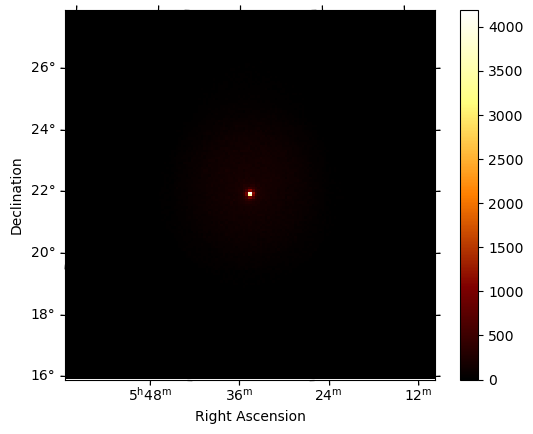

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [4]:
shift = +0.1
delta_tilt = 0.08
n = 24
tilt = delta_tilt/n 

N = 300
sigma_a = 0.1
sigma_i = tilt

save = True
save_flux = True




In [5]:
for n in range(N):
    try:
        print(n)
        shift_rnd = np.random.normal(0, shift, 1)
        tilt_rnd = np.random.normal(0, tilt, 1)
        print(f"shift:, {shift_rnd}, tilt: {tilt_rnd}" )
        sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_rnd, 
                        tilt = tilt_rnd,
                        rnd = True)
        dataset = sys_d_cor.create_dataset()
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([dataset])


        if save:
            with open("data/7a_P_draw_info.txt", "a") as myfile:
                myfile.write(str(float(shift_rnd)) + '    '+ str(float(tilt_rnd)) + '    ' +  str(float(dataset.stat_sum())) + '\n')

        stri = ""
        for p in ['amplitude', 'index', 'norm', 'tilt']:
            stri += str(dataset.models.parameters[p].value)  + '   ' +  str(dataset.models.parameters[p].error)  + '   '
        print(stri)
        if save:
            with open("data/7a_P_draw_par.txt", "a") as myfile:
                myfile.write(stri + '\n')


        mask = dataset.mask.data[:,60,60]

        ebins = dataset.counts.geom.axes[0].center[mask]
        fluxes = []
        for e in ebins:
            flux =  dataset.models[0].spectral_model(e)
            fluxes.append(flux.value)

        ff = str()
        for f in fluxes:
            ff += str(f) + "  "
        #print(ff)
        if save:
            with open("data/7a_P_draw_flux.txt", "a") as myfile:
                myfile.write( ff + '\n')


        energy_bounds = (ebins[0], ebins[-1] ) * u.TeV

        energy_min, energy_max = energy_bounds
        energy = MapAxis.from_energy_bounds(
            energy_min,
            energy_max,
            18,
        )

        fluxe2, _ = dataset.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
        fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
        fluxe2 = fluxe2.quantity[:, 0, 0]
        fluxe2 = np.array(fluxe2)   
        ff = str()
        for f in fluxe2:
            ff += str(f) + "  "
        if save:
            with open("data/7a_P_draw_flux2e.txt", "a") as myfile:
                myfile.write( ff + '\n')

        energy_edges = dataset.geoms['geom'].axes[0].edges
        esti  = FluxPointsEstimator(energy_edges= energy_edges)
        fluxpoints = esti.run([dataset])
        if save_flux:
            fluxpoints.write(f'data/fluxpoints/6_fluxpoints_{shift_rnd[0]:.6}.fits')
    except:
        pass


0
shift:, [-0.05139125], tilt: [0.00302715]
1.1840906896670202e-12   1.228325630773456e-13   2.3349493823300764   0.06228998212777358   1.0057359814171358   0.002078222372164901   0.0035722946113395833   0.001962017930828481   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 0.23560587257586868 0.9401725791795053
flux: len pen par: 0
norm 1.082263775502558 0.38323911423906026
flux: len pen par: 0
norm 0.8028118275728988 0.19255765392270957
flux: len pen par: 0
norm 1.2914107885040993 0.18019893119652558
flux: len pen par: 0
norm 0.9817726182102757 0.17591887083291535
flux: len pen par: 0
norm 0.649498178906262 0.17100354938310525
flux: len pen par: 0
norm 1.1779489684552498 0.2049469522194094
flux: len pen par: 0
norm 1.222165735691912 0.21636879424376856
flux: len pen par: 0
norm 1.2455432300013638 0.2478693268290139
flux: len pen par: 0
norm 0.602718796

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.3092679520693402 0.9745499265841547
flux: len pen par: 0
norm 0.9736684340362606 0.3690741707778509
flux: len pen par: 0
norm 1.0886725551381984 0.19861533266582418
flux: len pen par: 0
norm 0.872035728338715 0.1673591941026526
flux: len pen par: 0
norm 1.1617269796415481 0.18071019435060734
flux: len pen par: 0
norm 1.2244906498458146 0.18978740465973312
flux: len pen par: 0
norm 0.822394832915754 0.19462301363532666
flux: len pen par: 0
norm 0.7316597706225902 0.20634490443261683
flux: len pen par: 0
norm 0.926023937711645 0.23983581582191418
flux: len pen par: 0
norm 0.7702691385651225 0.2550924715215798
flux: len pen par: 0
norm 0.841125444025437 0.3020758731093285
flux: len pen par: 0
norm 1.1112429107850428 0.3627619746266457
flux: len pen par: 0
norm 1.3793637654359647 0.4282332536487337
flux: len pen par: 0
norm 1.0205578097

norm 0.4438899219382127 0.19935542056500236
flux: len pen par: 0
norm 1.1852710770509927 0.19350416977666035
flux: len pen par: 0
norm 1.1351502795140445 0.18959869340963514
flux: len pen par: 0
norm 0.8543165102465562 0.18962223629747818
flux: len pen par: 0
norm 1.1251872542834906 0.209030598373545
flux: len pen par: 0
norm 0.9693731057112822 0.2262300099035511
flux: len pen par: 0
norm 1.1458061140828322 0.25859300994095236
flux: len pen par: 0
norm 1.1935896322330122 0.28429553948012726
flux: len pen par: 0
norm 0.8121737265581199 0.2819677740793714
flux: len pen par: 0
norm 0.8878935669980434 0.32940579957763383
flux: len pen par: 0
norm 1.1325823592256166 0.3927499023033471
flux: len pen par: 0
norm 1.5923612472788278 0.5128790879704552
flux: len pen par: 0
norm 0.13839073942881847 0.338199787426589
flux: len pen par: 0
norm 0.5294765476460155 0.48556097796731734
flux: len pen par: 0
norm 0.7430835378296351 0.6469746662189323
flux: len pen par: 0
norm 1.496149257898878 0.93508188

norm 1.136623658356374 0.22069016347956782
flux: len pen par: 0
norm 1.1197463860985482 0.2414536732290049
flux: len pen par: 0
norm 0.8703899144815727 0.2516670364839473
flux: len pen par: 0
norm 0.930284298409219 0.28232447681686945
flux: len pen par: 0
norm 1.070934294249018 0.3328288928705818
flux: len pen par: 0
norm 0.668880545915314 0.3345751490730084
flux: len pen par: 0
norm 1.1187918397588636 0.45034630400615666
flux: len pen par: 0
norm 0.6783456127499443 0.4062262436284581
flux: len pen par: 0
norm 1.574445238196405 0.6151433057315713
flux: len pen par: 0
norm 2.392250137910532 0.8551373645567664
flux: len pen par: 0
norm -0.43799893994625305 0.14441635435195896
flux: len pen par: 0
norm -0.4478804945913821 1.7165383173100939
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
16
shift:, [0.06765609], tilt: [0.00437167]
7.920524916580783e-13   7.956956085603468e-14   2.1707908001683816   0.060403766769437546   0.9989239482504169   0.002063667173507521   -0.0008515435558488

norm 0.6640739655939881 0.25762033832553277
flux: len pen par: 0
norm 0.824758017791931 0.3084855615058764
flux: len pen par: 0
norm 1.0461703808571985 0.372376128662259
flux: len pen par: 0
norm 0.9299717766378947 0.4390314454277882
flux: len pen par: 0
norm 0.8726137423477358 0.5083409598944779
flux: len pen par: 0
norm 0.3818590776966882 0.39274628816165746
flux: len pen par: 0
norm 1.264745582049105 0.6258230337479133
flux: len pen par: 0
norm 1.9033247534603253 0.8983053016101149
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
21
shift:, [-0.0213094], tilt: [6.40167126e-05]
1.031617230755001e-12   9.21219822068592e-14   2.3534569762431823   0.06509893619587032   0.9996785773833505   0.002065094053379719   -0.0020079888145298984   0.0019581888559634564   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm -1.0831056297509358 0.8849391818409212
flux:

norm 2.6321072513837063 0.7289836893584053
flux: len pen par: 0
norm -0.05058607521880733 0.3427394321361917
flux: len pen par: 0
norm 2.56592577721926 1.0258695620990623
flux: len pen par: 0
norm 0.2461274861799731 0.5113811682137687
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
26
shift:, [-0.1012991], tilt: [-0.00234833]
9.633150421181733e-13   9.276451828199688e-14   2.263288001411462   0.06268093699493034   1.0006767602361284   0.0020655832097512044   -0.0015404235310346862   0.0019575490439049407   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.2057438046854945 1.205462613447173
flux: len pen par: 0
norm 1.1084149761094149 0.4750318993904629
flux: len pen par: 0
norm 0.5052758363284088 0.2130368040135378
flux: len pen par: 0
norm 1.0851881822012688 0.20223227954176784
flux: len pen par: 0
norm 1.2711747660513033 0.2030157961017269
flux: l

flux: len pen par: 0
31
shift:, [-0.01136648], tilt: [-0.00055152]
1.1828209649749752e-12   1.1237539578020028e-13   2.4391931675926357   0.06786009514553176   1.000829783793585   0.00207223296837911   0.0037066663956392457   0.0019678521972070788   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 0.24348476401337715 0.8016001712802163
flux: len pen par: 0
norm 1.2135652840911229 0.36051742465830855
flux: len pen par: 0
norm 0.8213785514416049 0.18051380548921056
flux: len pen par: 0
norm 0.957688214894185 0.16506181731904535
flux: len pen par: 0
norm 1.1771222013202864 0.1785775868697787
flux: len pen par: 0
norm 1.0127505062922812 0.18341700380244635
flux: len pen par: 0
norm 1.2123459971347095 0.20830195868987264
flux: len pen par: 0
norm 0.7391652452917273 0.22354963270442574
flux: len pen par: 0
norm 0.7778964515868694 0.24474613172777146
flux: len p

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.5873505726620178 1.31933838688827
flux: len pen par: 0
norm 1.0014869295279394 0.4705335579856572
flux: len pen par: 0
norm 0.6409107426261249 0.22821576431772814
flux: len pen par: 0
norm 1.0798542743422794 0.20146847731515327
flux: len pen par: 0
norm 1.1778279969868477 0.19967888105610135
flux: len pen par: 0
norm 1.0647832047303478 0.198815084712092
flux: len pen par: 0
norm 0.8222734108567671 0.19618478071426784
flux: len pen par: 0
norm 1.1386496368775556 0.22420002710388592
flux: len pen par: 0
norm 0.6981476644014184 0.2205563835669182
flux: len pen par: 0
norm 1.6022105893849798 0.29089138583635665
flux: len pen par: 0
norm 0.7321459324671525 0.25947150214565423
flux: len pen par: 0
norm 0.9262030203057918 0.30183951892716593
flux: len pen par: 0
norm 1.0322878815547545 0.3546565350992345
flux: len pen par: 0
norm 1.1276170

norm 0.9516699689632048 0.19546246042309973
flux: len pen par: 0
norm 1.1467952716064111 0.17357726799752296
flux: len pen par: 0
norm 0.7297940841532417 0.16107989824905658
flux: len pen par: 0
norm 1.199339216687094 0.1857940330276818
flux: len pen par: 0
norm 0.9956870135909227 0.19453412835533568
flux: len pen par: 0
norm 1.0489489788770217 0.2092914857348286
flux: len pen par: 0
norm 1.127367133686372 0.23794639832648354
flux: len pen par: 0
norm 0.4383192166316868 0.2251254365959164
flux: len pen par: 0
norm 1.5312346016632548 0.32811574799280696
flux: len pen par: 0
norm 0.8194874812979456 0.2926757090877306
flux: len pen par: 0
norm 1.6262079768758806 0.43081555701320207
flux: len pen par: 0
norm 0.45983026615032646 0.35175863641105637
flux: len pen par: 0
norm 0.7621543557361421 0.43565389821403894
flux: len pen par: 0
norm 0.6080944334510677 0.4637472586684737
flux: len pen par: 0
norm 1.9290015418140836 0.8268322495030992
flux: len pen par: 0
norm 0.6157829773883048 0.618512

norm 0.8300883718413055 0.17709218517451064
flux: len pen par: 0
norm 0.837774675954099 0.1918062083222128
flux: len pen par: 0
norm 0.941064068769635 0.21797917910790476
flux: len pen par: 0
norm 1.1872972486183604 0.252737158134909
flux: len pen par: 0
norm 1.403559194477196 0.2804389848181334
flux: len pen par: 0
norm 1.0036687391472154 0.2882536190388949
flux: len pen par: 0
norm 0.8891789750817074 0.31609422719494545
flux: len pen par: 0
norm 1.0603339195151427 0.38308639229202857
flux: len pen par: 0
norm 1.0670319445308325 0.42479337474148887
flux: len pen par: 0
norm 1.0338419945578665 0.45998581175956976
flux: len pen par: 0
norm 0.7618062367227877 0.4737760157847514
flux: len pen par: 0
norm 0.7505085355851352 0.5509564711909823
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
47
shift:, [-0.09043972], tilt: [0.00373446]
1.2785091068079503e-12   1.4098724415838982e-13   2.4311627121423065   0.07083431065103542   0.9995335213003508   0.0020742293717018   0.0003762787427073

norm 0.7154539800832423 0.22329857955728305
flux: len pen par: 0
norm 0.8848864222271158 0.26342286806256654
flux: len pen par: 0
norm 0.5616762135018334 0.2590941163996282
flux: len pen par: 0
norm 1.4452670680981796 0.3802921941951658
flux: len pen par: 0
norm 0.6116265420358761 0.3147757757044241
flux: len pen par: 0
norm 0.9672574208387782 0.42196993246151016
flux: len pen par: 0
norm 1.4488059835843048 0.5542919175600053
flux: len pen par: 0
norm 1.7594085813667981 0.6729601601073791
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
52
shift:, [0.23621853], tilt: [-0.00326921]
9.21243203851572e-13   8.798363481600378e-14   2.4396670122265847   0.0678008096767111   0.9966707996870761   0.0020666380685526436   -0.003399835268924643   0.0019602615121231755   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.026062314263883 0.8817879720395626
flux: l

norm 1.0981589812493364 0.4742640095173321
flux: len pen par: 0
norm 1.626115341824246 0.6370446957088757
flux: len pen par: 0
norm 2.1321019199934357 0.815244636035212
flux: len pen par: 0
norm 1.8449158668328338 0.9410545838147453
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
57
shift:, [-0.02051161], tilt: [-0.00060014]
1.127075232405741e-12   9.643049583417322e-14   2.3886846420617935   0.06375427437957816   0.9992413381591335   0.0020658852499512177   -4.7242698144410304e-05   0.0019621148617832507   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 0.6693909724452997 0.8616696238401892
flux: len pen par: 0
norm 0.9934240240180343 0.36425708811819135
flux: len pen par: 0
norm 1.1665380663692428 0.19248738034579155
flux: len pen par: 0
norm 0.6829649561139549 0.15872550581190553
flux: len pen par: 0
norm 1.2309086454511051 0.17435070773430641
fl

flux: len pen par: 0
62
shift:, [0.11301882], tilt: [0.0032483]
9.909996155785595e-13   8.405576274820622e-14   2.349795264863409   0.06256689107055453   0.9994043332478086   0.00206522935197254   -0.000830612476081507   0.0019605269329372   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.7667296436570006 1.0074524214048952
flux: len pen par: 0
norm 0.9458403206081003 0.36624703726160984
flux: len pen par: 0
norm 1.1612200802011847 0.19548273385427087
flux: len pen par: 0
norm 0.9396174091192147 0.16483532410553625
flux: len pen par: 0
norm 0.7243856391835317 0.16326353948337896
flux: len pen par: 0
norm 1.2311803393343588 0.1893604548977412
flux: len pen par: 0
norm 0.9921355095547963 0.1979915295615057
flux: len pen par: 0
norm 0.9663353618061182 0.21553131594000305
flux: len pen par: 0
norm 0.6207496220721272 0.2186308710818778
flux: len pen par: 0


flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.10767470435698 1.0437172003852098
flux: len pen par: 0
norm 1.3428032375333803 0.4401331183254643
flux: len pen par: 0
norm 1.0964213027643306 0.21750261795802484
flux: len pen par: 0
norm 1.2607766519930363 0.1910790888377337
flux: len pen par: 0
norm 0.8357752071837293 0.1796871542084648
flux: len pen par: 0
norm 0.9169442832741029 0.19085958493358693
flux: len pen par: 0
norm 0.6160274543559296 0.19370428862133923
flux: len pen par: 0
norm 0.8498149925273478 0.21543524418684964
flux: len pen par: 0
norm 1.1430341053927708 0.24492133834985597
flux: len pen par: 0
norm 1.1154483779731657 0.2754536146220014
flux: len pen par: 0
norm 0.9187900796165529 0.2984457447411009
flux: len pen par: 0
norm 0.9163029446072324 0.33418432098875106
flux: len pen par: 0
norm 1.6393370839859056 0.4488736064175473
flux: len pen par: 0
norm 0.94395011

norm 0.8785417376710134 0.18678921195585896
flux: len pen par: 0
norm 0.9012433297480843 0.1629377988293384
flux: len pen par: 0
norm 0.9245253250847599 0.16616077875859325
flux: len pen par: 0
norm 1.1404367026409556 0.1759762152463974
flux: len pen par: 0
norm 1.2687324690973416 0.1961790174322389
flux: len pen par: 0
norm 1.0952814546950544 0.20831817698209237
flux: len pen par: 0
norm 0.5267261306015165 0.19981423394160727
flux: len pen par: 0
norm 0.7033581065123871 0.23961311999431736
flux: len pen par: 0
norm 1.7264760194377697 0.3346672510722428
flux: len pen par: 0
norm 0.7221417334174444 0.2941729733186486
flux: len pen par: 0
norm 0.9552631134778365 0.36949391926824676
flux: len pen par: 0
norm 0.9974762797840065 0.45001077713687637
flux: len pen par: 0
norm 0.35229561801427667 0.3625173542545107
flux: len pen par: 0
norm 1.6311879286989923 0.710904181841414
flux: len pen par: 0
norm 0.34606989602227156 0.4694482048363183
flux: len pen par: 0
norm 2.620457491192051 1.1493339

norm 0.9250625011577366 0.19599893117097805
flux: len pen par: 0
norm 0.9913279454286282 0.21240400770125872
flux: len pen par: 0
norm 0.7051379179013917 0.2166171063823192
flux: len pen par: 0
norm 1.1826845853513142 0.2787463680312164
flux: len pen par: 0
norm 0.7913599780788526 0.2799277925401457
flux: len pen par: 0
norm 1.3728308426339322 0.3676148942857231
flux: len pen par: 0
norm 0.966849186426674 0.3780230615352026
flux: len pen par: 0
norm 1.141275850442976 0.4476392791822792
flux: len pen par: 0
norm 1.5409084521719567 0.5927670082840288
flux: len pen par: 0
norm 0.6801877066031995 0.5040402669574817
flux: len pen par: 0
norm -0.46508114951462326 0.12122807374681141
flux: len pen par: 0
norm 1.374532284874597 0.8380666547845241
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
78
shift:, [-0.16946894], tilt: [0.00234889]
1.1774389222847805e-12   1.2739703065932978e-13   2.3403643823534916   0.06879652665248927   1.0001782456155792   0.0020687733355618846   -0.003543043044

norm 0.9803124879208137 0.3019514322957417
flux: len pen par: 0
norm 0.7771539886469381 0.3193095239267203
flux: len pen par: 0
norm 1.9541024848970463 0.45920860279694387
flux: len pen par: 0
norm 0.3654653132997307 0.3351617143239737
flux: len pen par: 0
norm 1.1094476466367367 0.5209003478002527
flux: len pen par: 0
norm 0.6330083452709812 0.4629056251675047
flux: len pen par: 0
norm 0.9363066441063905 0.577712835614288
flux: len pen par: 0
norm 1.5022674930015785 0.9218391424720935
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
83
shift:, [-0.17407991], tilt: [-0.00396631]
1.2129449304427984e-12   1.05390205642063e-13   2.297446866729414   0.0586683852054981   1.0007977126904388   0.0020666711739969023   -0.00043573947039484236   0.001959741402234462   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 3.7513283401854935 1.219831776216012
flux: le

norm 0.5626246978688391 0.4128440539734358
flux: len pen par: 0
norm 0.8332293821603707 0.4914014047601425
flux: len pen par: 0
norm 0.6783644096103097 0.6345148952663487
flux: len pen par: 0
norm 4.330623434952757 1.3617248737710634
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
88
shift:, [0.08983426], tilt: [0.00240367]
9.409414436508198e-13   8.501856967054001e-14   2.320283385425657   0.06397711221794608   0.9960629302340318   0.0020616340579781758   -0.002986974819459085   0.0019603553243838045   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0759063207393447 1.026016007354887
flux: len pen par: 0
norm 1.1196282145311995 0.40993002174466486
flux: len pen par: 0
norm 0.9404798569711743 0.20373732096990077
flux: len pen par: 0
norm 0.8908049072145686 0.1752783633635834
flux: len pen par: 0
norm 1.3363734045426445 0.19206050045401732
flux: le

flux: len pen par: 0
93
shift:, [-0.22107891], tilt: [0.00016327]
1.0585290478487565e-12   1.0720751951290006e-13   2.1812589909690643   0.06039152710309152   0.999275070596835   0.002064736711347397   0.0009911735043745297   0.001963098140768614   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 2.321545267893207 1.4846487758578422
flux: len pen par: 0
norm 1.0722337494615444 0.5161159728973073
flux: len pen par: 0
norm 0.9829502019900302 0.2517753182096807
flux: len pen par: 0
norm 0.8782413574536635 0.21010160094031888
flux: len pen par: 0
norm 0.8410460081291466 0.2020489187478905
flux: len pen par: 0
norm 0.9878684809194037 0.2055846564805463
flux: len pen par: 0
norm 1.0465550033560627 0.2130359208140373
flux: len pen par: 0
norm 1.2278634240108746 0.236472586725769
flux: len pen par: 0
norm 0.9859871698825573 0.22936789245698733
flux: len pen par: 

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm -0.3475531978269092 0.9171487369299216
flux: len pen par: 0
norm 1.0637330837498156 0.37882971173032604
flux: len pen par: 0
norm 1.3385020605956446 0.20570007287641603
flux: len pen par: 0
norm 1.0400123328103825 0.17438858987668643
flux: len pen par: 0
norm 0.8774408109201547 0.16955803977938613
flux: len pen par: 0
norm 0.8478714815074047 0.1754953554882268
flux: len pen par: 0
norm 0.9918445420040484 0.19597948136070886
flux: len pen par: 0
norm 0.8633076218491238 0.20800281192297826
flux: len pen par: 0
norm 0.9043107181900729 0.22643853298617214
flux: len pen par: 0
norm 0.8985730327519914 0.25356406039488066
flux: len pen par: 0
norm 1.4526586441386902 0.3343556353702725
flux: len pen par: 0
norm 1.0347501764111708 0.3325226065051493
flux: len pen par: 0
norm 0.9298436099483735 0.3758451878050527
flux: len pen par: 0
norm 0.820

norm 1.622226971502542 0.35185642470077044
flux: len pen par: 0
norm 1.010698464470733 0.1707410123291379
flux: len pen par: 0
norm 1.0639446265591868 0.15453196700371477
flux: len pen par: 0
norm 1.0407136398299623 0.1588107653519238
flux: len pen par: 0
norm 0.8305577618616088 0.15905211867155997
flux: len pen par: 0
norm 0.6968150234431355 0.1686851828281226
flux: len pen par: 0
norm 1.2815964361716916 0.21028521304107486
flux: len pen par: 0
norm 0.9687465873443515 0.2218597223316776
flux: len pen par: 0
norm 0.9081863952274563 0.23641291410736634
flux: len pen par: 0
norm 0.4864455623458788 0.23897653029235835
flux: len pen par: 0
norm 0.8369518864064593 0.3257827331394571
flux: len pen par: 0
norm 1.6989564448153975 0.4266663277265241
flux: len pen par: 0
norm 0.49985273215129566 0.37722206898511806
flux: len pen par: 0
norm 1.8624334539514387 0.626963687867164
flux: len pen par: 0
norm 1.0363668716097405 0.5689540131126191
flux: len pen par: 0
norm 1.3145163986496882 0.900020655

norm 1.2334734216308578 0.19252983853357689
flux: len pen par: 0
norm 1.1269100624672268 0.20947597331359155
flux: len pen par: 0
norm 1.0655882678538766 0.22438493008330754
flux: len pen par: 0
norm 0.5317533371637906 0.20792834062331986
flux: len pen par: 0
norm 0.9061527289163381 0.26019137795780906
flux: len pen par: 0
norm 0.8602582290562214 0.30009193789569794
flux: len pen par: 0
norm 0.9646552120451748 0.338493762600101
flux: len pen par: 0
norm 1.0480692312373183 0.43259713126739724
flux: len pen par: 0
norm 1.308553442365801 0.4756061945745294
flux: len pen par: 0
norm 1.683129435152109 0.5923435681175871
flux: len pen par: 0
norm 0.3372094294936032 0.45161659509913715
flux: len pen par: 0
norm 1.1160895364020782 0.6838998157087826
flux: len pen par: 0
norm 1.7716095427880583 0.9922724410852108
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
109
shift:, [0.07631049], tilt: [0.00456786]
1.0067310476236649e-12   8.800256402482812e-14   2.322833856168352   0.061877572200253

norm 1.1271361505813258 0.27207262758312406
flux: len pen par: 0
norm 1.1789972449704884 0.2981484515701182
flux: len pen par: 0
norm 1.1815690997415988 0.33683777453009417
flux: len pen par: 0
norm 1.1718413586517091 0.38069274437085887
flux: len pen par: 0
norm 1.0913698980728523 0.4191093264885881
flux: len pen par: 0
norm 1.775055034762788 0.5682725938577057
flux: len pen par: 0
norm 0.10743422268744113 0.2982439617648462
flux: len pen par: 0
norm 0.4779803020094623 0.42663075086415453
flux: len pen par: 0
norm 0.5094735395735177 0.5477040363170392
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
114
shift:, [-0.23014012], tilt: [0.00158646]
1.4625534035995584e-12   1.469906624229051e-13   2.360752201500262   0.06454195082508934   0.9995239905979196   0.0020704794464766457   -0.0003910852816595359   0.0019620962100763395   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
f

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


118
shift:, [-0.03003279], tilt: [-0.00414441]
1.080643803978568e-12   1.0290495523568727e-13   2.36913159562761   0.06395309254526275   1.0003327405253608   0.002069241983376454   0.0011416458832932438   0.0019640680397303664   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 0.4795739461850913 0.904226616001903
flux: len pen par: 0
norm 0.5146226238942089 0.356973370752907
flux: len pen par: 0
norm 1.1530518239476863 0.1999974691774124
flux: len pen par: 0
norm 0.7836854117587372 0.16723152732719895
flux: len pen par: 0
norm 1.0448541666631102 0.17378532887197878
flux: len pen par: 0
norm 1.4979738837397552 0.19917188311302012
flux: len pen par: 0
norm 1.056799623690781 0.19722313844410888
flux: len pen par: 0
norm 0.3978506297227412 0.19244860458687668
flux: len pen par: 0
norm 1.2921026443163657 0.25354314169209063
flux: len pen par: 0
norm 0.98881726

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 2.3546792575771214 1.118029368658486
flux: len pen par: 0
norm 1.1084727343928773 0.38807747139520404
flux: len pen par: 0
norm 0.8846381676104567 0.19678987454129435
flux: len pen par: 0
norm 0.9385052620421074 0.17214465148928948
flux: len pen par: 0
norm 1.3018899465778784 0.18203690932131167
flux: len pen par: 0
norm 0.9915436769426945 0.18145439750062053
flux: len pen par: 0
norm 0.7354640306730404 0.18495826010048932
flux: len pen par: 0
norm 0.9827770367100165 0.20981150370240634
flux: len pen par: 0
norm 0.8653363429523824 0.22728472363699567
flux: len pen par: 0
norm 0.7322438953506194 0.2369924443715391
flux: len pen par: 0
norm 0.8151837561569361 0.2685897368031194
flux: len pen par: 0
norm 1.6248139685351533 0.3689559754790681
flux: len pen par: 0
norm 1.336417724719043 0.38607317867889
flux: len pen par: 0
norm 1.54637461

norm 1.1046874334852559 0.2258664198351682
flux: len pen par: 0
norm 0.8085502758045644 0.1852269014619041
flux: len pen par: 0
norm 0.8936893539460798 0.1856093423410374
flux: len pen par: 0
norm 0.9079145510187469 0.18960231626250318
flux: len pen par: 0
norm 1.137025217138555 0.20685285180301693
flux: len pen par: 0
norm 1.243238331883409 0.23230002091140578
flux: len pen par: 0
norm 1.3037221395839746 0.25527592329572035
flux: len pen par: 0
norm 0.8769188393346493 0.2564217243591764
flux: len pen par: 0
norm 1.3064818786725996 0.30886495141435927
flux: len pen par: 0
norm 0.5835155356634992 0.28418616152268567
flux: len pen par: 0
norm 1.0613232746227101 0.38590175649397307
flux: len pen par: 0
norm 1.0506046157198672 0.4020547157598789
flux: len pen par: 0
norm 0.5244078247574742 0.38031101880796214
flux: len pen par: 0
norm 0.8248281857822188 0.5103204339376662
flux: len pen par: 0
norm 0.5364280899317007 0.4723560500755662
flux: len pen par: 0
norm 1.4173181269095871 0.78824823

norm 1.0647566397857138 0.2015753315748534
flux: len pen par: 0
norm 0.7240490208827149 0.20608180358986378
flux: len pen par: 0
norm 0.6689234589839356 0.20198522853537426
flux: len pen par: 0
norm 0.9087398468001041 0.23003399767833455
flux: len pen par: 0
norm 1.3235177843746546 0.28738057487276125
flux: len pen par: 0
norm 1.0851306624690782 0.30610568862446286
flux: len pen par: 0
norm 1.2168320969341726 0.3450236235288346
flux: len pen par: 0
norm 1.2667372259963163 0.3913796329844836
flux: len pen par: 0
norm 1.226212936523995 0.4325070484926013
flux: len pen par: 0
norm 0.3238831288669683 0.3105629505997371
flux: len pen par: 0
norm 1.4523567502730765 0.5976927270974657
flux: len pen par: 0
norm 0.9285361560419119 0.5479574143375576
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
134
shift:, [-0.00164701], tilt: [0.0009471]
1.093548403217295e-12   9.339297046611407e-14   2.3189568717978997   0.06031216293907218   0.9953521616320622   0.002060739013386791   -0.0047836160300

norm 0.9720645330975975 0.29650349756528055
flux: len pen par: 0
norm 0.9277724366720073 0.329484038502904
flux: len pen par: 0
norm 1.458075116497121 0.43933535149754316
flux: len pen par: 0
norm 0.7073178960081608 0.41262956394276185
flux: len pen par: 0
norm 0.053061920793004064 0.2914963530548813
flux: len pen par: 0
norm 1.3800996250606914 0.5971042518685123
flux: len pen par: 0
norm 0.8546031451348312 0.6094529951366395
flux: len pen par: 0
norm 2.26101831270056 1.131332138847032
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
139
shift:, [-0.08193579], tilt: [0.00188788]
1.1186120063889358e-12   1.0377703464805738e-13   2.3859938576722723   0.07017431795221997   0.9983092438045645   0.0020573441876535307   -0.001993873399777101   0.001954174030364497   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.5794595579019892 1.037811428294075
flux: 

norm 1.410060463891532 0.5960363933178099
flux: len pen par: 0
norm 1.036995936575309 0.638449384110568
flux: len pen par: 0
norm 0.013298765165316577 0.382453090276244
flux: len pen par: 0
norm 0.7057237191329654 0.8110063655378331
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
144
shift:, [-0.0243587], tilt: [-0.00071307]
1.000491029158967e-12   1.0736970745955525e-13   2.3390190692807686   0.06835285216460854   0.9986616600384538   0.002067781099603464   -0.0033972607273093946   0.0019579780687779434   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 0.30028696664257093 1.0552329462548438
flux: len pen par: 0
norm 0.5319456795920872 0.3962142454534823
flux: len pen par: 0
norm 1.0688636046837394 0.2260721677858648
flux: len pen par: 0
norm 1.213187823774609 0.1972745504158398
flux: len pen par: 0
norm 1.0646477490107096 0.19832888181083597
flux: 

149
shift:, [-0.05236363], tilt: [-0.00560916]
9.21731210842456e-13   8.554475462495507e-14   2.2393513613241725   0.05891598923284047   0.9972922976293118   0.002062237408683505   -0.0009467362177102542   0.0019620995457491834   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.343052244330312 1.1959457091213508
flux: len pen par: 0
norm 1.212906827094788 0.45767648430902924
flux: len pen par: 0
norm 1.009528717721267 0.22773418371546292
flux: len pen par: 0
norm 0.8696958310871875 0.1887254302027888
flux: len pen par: 0
norm 0.7250410590081313 0.18007617185339456
flux: len pen par: 0
norm 1.1453086409188722 0.1945219667935138
flux: len pen par: 0
norm 1.1218274843334 0.20797261335479805
flux: len pen par: 0
norm 0.9557611905872083 0.21325982105846442
flux: len pen par: 0
norm 1.332199650582053 0.2461411200339541
flux: len pen par: 0
norm 1.251967199161

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 2.469634223289414 1.3280647781978854
flux: len pen par: 0
norm 1.2005928068290517 0.4715994233877763
flux: len pen par: 0
norm 0.9545725983087867 0.22737270555131026
flux: len pen par: 0
norm 0.6063661703263522 0.18421729745711485
flux: len pen par: 0
norm 1.0198455777280735 0.19490221060448193
flux: len pen par: 0
norm 1.2754342612841933 0.20611787759680603
flux: len pen par: 0
norm 1.1554151065597582 0.21359277586092681
flux: len pen par: 0
norm 0.98357844243517 0.2185213827755185
flux: len pen par: 0
norm 1.065903556393465 0.24304382284020423
flux: len pen par: 0
norm 1.0468132741090383 0.26164908980565577
flux: len pen par: 0
norm 0.8615287908238256 0.2737063196025546
flux: len pen par: 0
norm 1.0261635496989072 0.31220608696822666
flux: len pen par: 0
norm 0.8740550121113978 0.34949162825143665
flux: len pen par: 0
norm 0.6155604

norm 0.3341302937306303 0.20153648831334248
flux: len pen par: 0
norm 0.8926504983057444 0.19077490030758693
flux: len pen par: 0
norm 1.359207690369867 0.20492800718872267
flux: len pen par: 0
norm 0.8867354504659716 0.20241711720674507
flux: len pen par: 0
norm 1.3653891486818301 0.23230390166518577
flux: len pen par: 0
norm 1.5056540995588559 0.25721902006368175
flux: len pen par: 0
norm 0.8422385514298155 0.25057847424539637
flux: len pen par: 0
norm 1.283954419509837 0.308765277277968
flux: len pen par: 0
norm 0.892493979995279 0.3044861825363836
flux: len pen par: 0
norm 0.7781402838131362 0.3547899218293585
flux: len pen par: 0
norm 0.5116283073829602 0.35945111383387685
flux: len pen par: 0
norm 0.6307472519760616 0.44286164991930776
flux: len pen par: 0
norm 0.05073779226300893 0.34753673602566776
flux: len pen par: 0
norm 1.039385900966548 0.6283347199123812
flux: len pen par: 0
norm 1.5983088369709153 0.8551001785145086
flux: len pen par: 0
norm 1.1751839162440325 0.93141070

norm 1.0351024082397389 0.19647792562808075
flux: len pen par: 0
norm 1.0068314696116758 0.21030994049379592
flux: len pen par: 0
norm 0.9559830628366583 0.22058778600322582
flux: len pen par: 0
norm 0.6980715335843835 0.217699199057539
flux: len pen par: 0
norm 1.3003593842627006 0.2788486004581437
flux: len pen par: 0
norm 1.4907159713697522 0.3267446859846919
flux: len pen par: 0
norm 1.0920688493202226 0.33241792400086745
flux: len pen par: 0
norm 0.8635323388740026 0.33056734284983946
flux: len pen par: 0
norm 1.065097705097986 0.45089138967430153
flux: len pen par: 0
norm 0.9642905534129612 0.4605727342072777
flux: len pen par: 0
norm 0.4274039332132923 0.3786199597058455
flux: len pen par: 0
norm 0.4986298321085506 0.47106849570776477
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
165
shift:, [0.05278376], tilt: [-0.00098602]
8.57564432060035e-13   8.01383900562691e-14   2.220857602097185   0.059078226775512416   1.0010581709964521   0.0020375080311216894   0.0025665080881

norm 0.8778654264332936 0.26934276415309394
flux: len pen par: 0
norm 0.7019724575004727 0.2863906834611483
flux: len pen par: 0
norm 0.8849995579187897 0.35819021367473164
flux: len pen par: 0
norm 1.2095334655494734 0.4116997480959779
flux: len pen par: 0
norm 0.7267703260861942 0.38784069190553294
flux: len pen par: 0
norm 0.893006835857281 0.49837612623004685
flux: len pen par: 0
norm 1.777105873571214 0.6704844197263651
flux: len pen par: 0
norm 0.8708738250724761 0.6006418597679343
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
170
shift:, [-0.07097837], tilt: [-0.00038615]
9.941349386564685e-13   9.402556187929837e-14   2.2767096465191052   0.0633695764232126   0.9979093879428454   0.0020632683990474427   -0.0013582030444152333   0.001960968983205133   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 2.2428410864620063 1.1970831773661101
flux

norm 0.7052420941357072 0.49484932453233416
flux: len pen par: 0
norm 0.7425765439299254 0.5550880128023922
flux: len pen par: 0
norm 1.3305550396591492 0.8554899491360444
flux: len pen par: 0
norm 1.160596939153376 0.9019896646717985
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
175
shift:, [-0.07327047], tilt: [-0.00316856]
1.0952929703564435e-12   9.635373671354714e-14   2.32520629208219   0.060942825675848966   1.0015183322453454   0.0020673613462652792   -0.0024204284304137264   0.001955776341472366   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.5496427920181761 1.0667889066900629
flux: len pen par: 0
norm 1.6813142169642172 0.419450094470994
flux: len pen par: 0
norm 0.7914659880406766 0.19356849587894068
flux: len pen par: 0
norm 1.0122517860877087 0.17511068350711761
flux: len pen par: 0
norm 1.0355878566251215 0.17768058084843152
flu

180
shift:, [-0.19687191], tilt: [0.00380137]
1.3901501222991119e-12   1.1661219717534386e-13   2.3128038655697916   0.05931217577618149   0.9979086851523989   0.0020637139687628113   0.0007120845892258884   0.001964197636846887   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm -0.7271765179593787 0.8254004497389744
flux: len pen par: 0
norm 0.6778255816079639 0.3649829967439813
flux: len pen par: 0
norm 1.268702859442089 0.20115973943548668
flux: len pen par: 0
norm 0.7704217514788881 0.1646431650686362
flux: len pen par: 0
norm 0.9818313115177719 0.17108227250640762
flux: len pen par: 0
norm 0.9601915725733936 0.1769939924729223
flux: len pen par: 0
norm 1.1040324187666053 0.19310878322091388
flux: len pen par: 0
norm 0.9965087921839758 0.2113684483333372
flux: len pen par: 0
norm 1.1684437360754185 0.2406924670683774
flux: len pen par: 0
norm 1.311414

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 0.4518530328087537 1.0945456541678187
flux: len pen par: 0
norm 0.9662377785996433 0.43142421788667434
flux: len pen par: 0
norm 0.8579663736560295 0.21718998367221182
flux: len pen par: 0
norm 0.885664823725432 0.18957681289118913
flux: len pen par: 0
norm 1.2484266214010813 0.19919999574748987
flux: len pen par: 0
norm 0.8609067053131197 0.19699310190200456
flux: len pen par: 0
norm 1.1592264433383836 0.21606101835181485
flux: len pen par: 0
norm 1.4029182730400338 0.24423249849331874
flux: len pen par: 0
norm 0.5078314817662578 0.22185683263566855
flux: len pen par: 0
norm 0.9446265624873376 0.26465570463368315
flux: len pen par: 0
norm 0.8512984047811768 0.29917544880649766
flux: len pen par: 0
norm 1.4231857102647751 0.38987406550030346
flux: len pen par: 0
norm 0.9728432337997852 0.3819189420035549
flux: len pen par: 0
norm 1.51

norm 1.2849062956546144 0.49889685032072656
flux: len pen par: 0
norm 0.9906567278135102 0.24284408247513772
flux: len pen par: 0
norm 1.1829886739314324 0.20845192423278724
flux: len pen par: 0
norm 1.0891569979039344 0.202031934513107
flux: len pen par: 0
norm 0.7339954571323005 0.19544568844136592
flux: len pen par: 0
norm 0.8689950969742307 0.20487349027625584
flux: len pen par: 0
norm 0.8545266695460026 0.22062875237321114
flux: len pen par: 0
norm 0.9507738545078392 0.24395952049724515
flux: len pen par: 0
norm 1.0444814303998502 0.26753873594349836
flux: len pen par: 0
norm 1.7008275108954318 0.34518610002935607
flux: len pen par: 0
norm 0.7343017112842061 0.3054385845544183
flux: len pen par: 0
norm 1.940487015198995 0.4587727912963621
flux: len pen par: 0
norm 0.6812640258274634 0.3663044447771858
flux: len pen par: 0
norm 0.3906955616001072 0.35004144718355956
flux: len pen par: 0
norm 0.6159106622545534 0.44951183223398866
flux: len pen par: 0
norm 0.7439029758772355 0.52745

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


194
shift:, [0.021634], tilt: [0.00679975]
9.868682657298659e-13   9.258912538498751e-14   2.282325437346249   0.06442455740615884   0.9973326044762224   0.002062783659183455   -0.002941208181270019   0.0019589449761632785   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 2.8897023959754837 1.1765124345031615
flux: len pen par: 0
norm 0.5331210450922799 0.3984250792964809
flux: len pen par: 0
norm 1.0319447024621622 0.2197478046025316
flux: len pen par: 0
norm 0.978541313785547 0.18529334233785702
flux: len pen par: 0
norm 1.2673597960371632 0.19615108999361144
flux: len pen par: 0
norm 0.773385005717001 0.1879963873458343
flux: len pen par: 0
norm 0.9097138501305737 0.2011474646870566
flux: len pen par: 0
norm 1.0857616273043 0.22841040689611966
flux: len pen par: 0
norm 0.7587640491168479 0.2251128683401688
flux: len pen par: 0
norm 0.974776292026113 0

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.8130633882807532 1.1002334554387891
flux: len pen par: 0
norm 0.9304909017857725 0.40351204257856965
flux: len pen par: 0
norm 1.2313132602834829 0.2138745938672076
flux: len pen par: 0
norm 1.0046634964381946 0.1805871910330021
flux: len pen par: 0
norm 0.7774523014022431 0.17480804706369427
flux: len pen par: 0
norm 1.0190083000617718 0.19233883419620187
flux: len pen par: 0
norm 0.5757189852186809 0.19132697820656872
flux: len pen par: 0
norm 1.3019489265572157 0.24280104870669397
flux: len pen par: 0
norm 1.042561604061469 0.2502551603729672
flux: len pen par: 0
norm 1.2812362096503607 0.2966509597468126
flux: len pen par: 0
norm 0.7392369516496761 0.28876041636653477
flux: len pen par: 0
norm 1.246208295735004 0.3677701952280218
flux: len pen par: 0
norm 1.5797986920371145 0.45644364752126226
flux: len pen par: 0
norm 0.9873912

norm 0.9935721870410413 0.20678772503093842
flux: len pen par: 0
norm 1.1393681529114814 0.182879920180027
flux: len pen par: 0
norm 0.8545119147395077 0.1789830058527429
flux: len pen par: 0
norm 0.9896051425739979 0.18936053076894888
flux: len pen par: 0
norm 1.0575793757716163 0.2048096534862486
flux: len pen par: 0
norm 0.9281834737287379 0.22155126723046673
flux: len pen par: 0
norm 1.105658231884272 0.24854225033442515
flux: len pen par: 0
norm 1.3686467312334334 0.29329967483260516
flux: len pen par: 0
norm 0.5332481166063203 0.2637076006469515
flux: len pen par: 0
norm 0.9776427792751077 0.3488759993850218
flux: len pen par: 0
norm 0.5026930863445886 0.3158709345488434
flux: len pen par: 0
norm 0.7655801512700645 0.4056793705700894
flux: len pen par: 0
norm 0.9976346684311452 0.5130218946307143
flux: len pen par: 0
norm 1.299485311858244 0.605746349539137
flux: len pen par: 0
norm 1.0251543118701612 0.6176378462733885
flux: len pen par: 0
norm 2.4753158965773445 1.0939447494713

norm 1.2555115897437725 0.2104087436779477
flux: len pen par: 0
norm 0.8031190960625907 0.21548862452148182
flux: len pen par: 0
norm 0.5881274463863317 0.21845055595478619
flux: len pen par: 0
norm 1.040242805954303 0.28411059479688855
flux: len pen par: 0
norm 0.9919753283820514 0.2997679522447113
flux: len pen par: 0
norm 0.7726802805772048 0.32197530521571865
flux: len pen par: 0
norm 1.1845322328122836 0.40371148284471536
flux: len pen par: 0
norm 1.2122049336008927 0.45084099060571275
flux: len pen par: 0
norm 0.7746007283473076 0.4606657486421257
flux: len pen par: 0
norm 0.5924292365399817 0.4827074329809922
flux: len pen par: 0
norm 1.6887809448819249 0.8712151608780229
flux: len pen par: 0
norm 1.48083012647727 0.9164537039666304
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
210
shift:, [-0.01225773], tilt: [-0.00530216]
8.983963270706654e-13   9.203337019439966e-14   2.2349818076593873   0.06125221351339885   0.9981721541145676   0.0020655117794613274   -0.00031867198

norm 1.1233958039423169 0.33723861484970824
flux: len pen par: 0
norm 0.6417509608912053 0.354699717001424
flux: len pen par: 0
norm 1.3873458455526528 0.49573433312342446
flux: len pen par: 0
norm 0.901958367230217 0.5063277680181844
flux: len pen par: 0
norm 0.31996566999195725 0.46083336228193095
flux: len pen par: 0
norm 2.1287377443231965 0.8837053089986
flux: len pen par: 0
norm 1.0433947063542277 0.8372755578740791
flux: len pen par: 0
norm -6.982856425607569 5.8687381254014195
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
215
shift:, [0.12238764], tilt: [0.00095052]
8.701682164786179e-13   7.945069973207649e-14   2.2637509125226583   0.060291835373104105   1.0017624853231484   0.0020677983962878537   0.00044682927174028667   0.0019601382138637515   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 0.32062515274087267 1.0421614695751111
flux:

norm 0.6157050559777095 0.3786086134843562
flux: len pen par: 0
norm 1.1143917839892865 0.5067377273401064
flux: len pen par: 0
norm 1.4691936650064998 0.6877268990259247
flux: len pen par: 0
norm 0.5371286051836676 0.6611719907468918
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
220
shift:, [-0.02067756], tilt: [-0.00051449]
9.164608770277289e-13   8.796996486617434e-14   2.248032065267782   0.06141055301717301   0.9990695379906848   0.002064603194042231   0.0003107151615323782   0.001962259813570719   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.850056044467473 1.289767917567924
flux: len pen par: 0
norm 0.5429453611392219 0.4385779751647812
flux: len pen par: 0
norm 1.2293128997654572 0.23240516331083658
flux: len pen par: 0
norm 0.861714716381814 0.18964418892911683
flux: len pen par: 0
norm 0.7998977369031548 0.18624111491094836
flux: le

225
shift:, [-0.04603571], tilt: [0.00480765]
1.0245071308833312e-12   6.776978556924901e-14   2.3377850430010683   0.026329942991371105   0.9984470009942393   0.0017765782330212351   -0.00022180700984041486   0.0016919784789368442   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.544548561531103 1.108685348432408
flux: len pen par: 0
norm 1.792753073006917 0.46149907070435714
flux: len pen par: 0
norm 1.1678683769005467 0.22462821119633555
flux: len pen par: 0
norm 0.8990249332430813 0.1875797839425766
flux: len pen par: 0
norm 0.8295072883215424 0.19187821894502433
flux: len pen par: 0
norm 0.9011910973527963 0.1995257644802238
flux: len pen par: 0
norm 1.029260724901373 0.21817710324915718
flux: len pen par: 0
norm 1.0028566141091582 0.23958315876511085
flux: len pen par: 0
norm 0.968616527004692 0.26396199678863536
flux: len pen par: 0
norm 0.97537

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm -0.06125637807465842 1.0903103552452462
flux: len pen par: 0
norm 1.2541522786773895 0.46640930001554526
flux: len pen par: 0
norm 0.8498685305133021 0.22056162678024757
flux: len pen par: 0
norm 0.9076016475417684 0.18619335625574937
flux: len pen par: 0
norm 1.1841030917159803 0.1946394756048734
flux: len pen par: 0
norm 0.7880517445696628 0.18977054609003763
flux: len pen par: 0
norm 1.4938199308795719 0.2186640633990201
flux: len pen par: 0
norm 1.0069865686806525 0.21897823361842136
flux: len pen par: 0
norm 0.9315971722502201 0.23140158429462598
flux: len pen par: 0
norm 0.8966240955668521 0.25489707915233195
flux: len pen par: 0
norm 0.8550700692273041 0.2692886044992771
flux: len pen par: 0
norm 0.6569598239099581 0.2727780143095067
flux: len pen par: 0
norm 0.8516251619553431 0.3413247062438899
flux: len pen par: 0
norm 0.954

norm 1.1890798752417029 0.4114152588620466
flux: len pen par: 0
norm 0.8939862562647886 0.2075249199291442
flux: len pen par: 0
norm 1.0129931788606654 0.17773633271744294
flux: len pen par: 0
norm 1.0592107457520121 0.18018561946742875
flux: len pen par: 0
norm 1.0837504847063144 0.18214903941754887
flux: len pen par: 0
norm 0.7252518482781389 0.18122797124584913
flux: len pen par: 0
norm 1.235572796631327 0.22113068782067125
flux: len pen par: 0
norm 1.1352004357924665 0.22975412138643353
flux: len pen par: 0
norm 1.01807862749051 0.2405629422673207
flux: len pen par: 0
norm 0.5537446979043864 0.2398986535169457
flux: len pen par: 0
norm 0.9985121322024494 0.3091607017644654
flux: len pen par: 0
norm 1.0464948934913918 0.3401094969094726
flux: len pen par: 0
norm 1.3556408571235303 0.45792434493352185
flux: len pen par: 0
norm 0.9906521448440774 0.4160980135885853
flux: len pen par: 0
norm 1.0489749612882635 0.49805612607806954
flux: len pen par: 0
norm 0.7708147050949505 0.552059835

norm 1.408644805223919 0.22202734301969
flux: len pen par: 0
norm 1.1520241763412689 0.22426345886103924
flux: len pen par: 0
norm 0.938819703693818 0.22811938505168192
flux: len pen par: 0
norm 0.8561945561222475 0.23188758260882358
flux: len pen par: 0
norm 0.4988466330138168 0.22001911847796427
flux: len pen par: 0
norm 1.027982396006855 0.2925159124267958
flux: len pen par: 0
norm 1.149871167087252 0.33336866221350653
flux: len pen par: 0
norm 1.3579045128293377 0.3801413666865341
flux: len pen par: 0
norm 1.2099669243297693 0.41466737806351944
flux: len pen par: 0
norm 0.8109444085843808 0.4229070041759491
flux: len pen par: 0
norm 0.8991331120054472 0.475079280744947
flux: len pen par: 0
norm 0.9684503979090685 0.4930382588424401
flux: len pen par: 0
norm 1.059959994597025 0.6637930050790388
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
241
shift:, [0.10837177], tilt: [4.90346869e-06]
9.567675753492713e-13   8.982887311441631e-14   2.4095472114628693   0.06857148607617922 

norm 1.6425926334219167 0.28128095973071465
flux: len pen par: 0
norm 0.507208796040042 0.23354174407161082
flux: len pen par: 0
norm 0.8979993157133884 0.29842195923442977
flux: len pen par: 0
norm 1.4762230198622237 0.3999127597248371
flux: len pen par: 0
norm 1.0532074896128767 0.37193722263281037
flux: len pen par: 0
norm 0.5867833408530274 0.36332940767659194
flux: len pen par: 0
norm 1.6477926401127623 0.5497231564533344
flux: len pen par: 0
norm 0.8130961376312527 0.5006586132131986
flux: len pen par: 0
norm 0.5633730714773955 0.5244819249796102
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
246
shift:, [-0.07223828], tilt: [0.00270883]
1.0085247928540046e-12   1.0493186908103299e-13   2.1883458848480153   0.05936343719470897   1.0027208941182348   0.002070314537008842   -0.0004121354412714714   0.001959023354659248   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
f

norm 0.5395683890836537 0.3905812759082908
flux: len pen par: 0
norm 1.0178006263027437 0.4535123014229561
flux: len pen par: 0
norm 0.9751721459380206 0.5402203727323149
flux: len pen par: 0
norm 0.6196373537056398 0.5469812164383424
flux: len pen par: 0
norm -0.3533448879236275 0.654844490195719
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
251
shift:, [-0.09553778], tilt: [-0.00109769]
1.0859825062321938e-12   9.842073760832717e-14   2.339475794364596   0.065219503264042   1.0005112601321755   0.002066279626147041   -0.0004715616793483604   0.001960027076243572   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm -0.1093867856734893 0.9755075322872016
flux: len pen par: 0
norm 0.8167968905309779 0.3976020874324674
flux: len pen par: 0
norm 1.088188313562575 0.20814115445962594
flux: len pen par: 0
norm 0.9750826824499322 0.17954750353031057
flux: 

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/gammapy/gammapy/modeling/models/spatial.py:554: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


8.623124808901407e-13   8.156133517629649e-14   2.366475158436839   0.06920536771422499   0.9983560737653482   0.0020635880536028547   -0.002751366039322286   0.0019578790125249516   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 0.3061651500082054 1.0548944364267272
flux: len pen par: 0
norm 0.8081898929464497 0.41118601627826795
flux: len pen par: 0
norm 0.9122938931662237 0.20981335068547421
flux: len pen par: 0
norm 0.9776609829831102 0.18887315272397065
flux: len pen par: 0
norm 1.1224131009167875 0.20108526152123116
flux: len pen par: 0
norm 1.0725023021386064 0.2063963284886623
flux: len pen par: 0
norm 1.0011229093044114 0.2185070020680326
flux: len pen par: 0
norm 1.0416768688869762 0.246787270454203
flux: len pen par: 0
norm 0.6263717822443747 0.24326083176767935
flux: len pen par: 0
norm 1.4313825112463456 0.31703033309284495
flux: len pen pa

norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 0.4186463102146954 0.9890367147058061
flux: len pen par: 0
norm 1.0323543412842413 0.40379399230546864
flux: len pen par: 0
norm 0.7221503700232407 0.19524750794262044
flux: len pen par: 0
norm 0.8986390532975957 0.16776295660031923
flux: len pen par: 0
norm 1.304682748496428 0.18115252680131416
flux: len pen par: 0
norm 1.075092941798875 0.18159577337703944
flux: len pen par: 0
norm 0.8119152765924041 0.1830718145218088
flux: len pen par: 0
norm 1.071460266532304 0.2084143515499253
flux: len pen par: 0
norm 1.3104913635918156 0.23382108593026024
flux: len pen par: 0
norm 0.9868749830234351 0.23755812928713088
flux: len pen par: 0
norm 0.6994540208832131 0.25406837081984707
flux: len pen par: 0
norm 1.0290319590642902 0.3011407751303044
flux: len pen par: 0
norm 1.1430442454023313 0.36327393633251365
flux: len pen par: 0
norm 0.7555544906677241 0.35082483386958124
flux: len pen par: 0
n

norm 0.9014290396570785 0.18863364241697272
flux: len pen par: 0
norm 0.8925413998841047 0.16552253814374135
flux: len pen par: 0
norm 1.040427232920134 0.16767102198061082
flux: len pen par: 0
norm 1.0488160318814064 0.1748842918563871
flux: len pen par: 0
norm 0.7790996599728965 0.1799258712995609
flux: len pen par: 0
norm 1.180174256680159 0.21308037278482214
flux: len pen par: 0
norm 0.7460160268426668 0.21315041263871928
flux: len pen par: 0
norm 1.0999769793226863 0.2536410115704554
flux: len pen par: 0
norm 1.1527452708521622 0.29626781475574276
flux: len pen par: 0
norm 0.8690225289901371 0.2960266621515787
flux: len pen par: 0
norm 1.1982589151435463 0.38392725167856273
flux: len pen par: 0
norm 1.4033202045544089 0.46315631656758055
flux: len pen par: 0
norm 0.8394255578661332 0.45156862462556646
flux: len pen par: 0
norm 0.9854601354987522 0.5521059191570081
flux: len pen par: 0
norm 1.5426619274060605 0.7358968742011016
flux: len pen par: 0
norm -0.28901513891785824 0.11428

norm 1.1237137273050204 0.19116377953045258
flux: len pen par: 0
norm 1.2323625061772192 0.21868390582969682
flux: len pen par: 0
norm 0.9542053066548549 0.22467257088912718
flux: len pen par: 0
norm 1.4194046538850629 0.280753374091212
flux: len pen par: 0
norm 0.8221403419998863 0.278341035348929
flux: len pen par: 0
norm 0.5039876768012175 0.2889044575904991
flux: len pen par: 0
norm 0.9114157833175842 0.35283548385008595
flux: len pen par: 0
norm 0.9363316844298254 0.40336219287930775
flux: len pen par: 0
norm 1.5354727617800823 0.545743409796584
flux: len pen par: 0
norm 0.6013356060068249 0.4349875801667471
flux: len pen par: 0
norm 0.7510835781894901 0.5727698647983956
flux: len pen par: 0
norm 0.6599449866790711 0.6457451880905264
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
271
shift:, [0.02311018], tilt: [-0.00078658]
9.464619442868825e-13   8.759846929788055e-14   2.261497646131677   0.05988832290381314   0.9993731550702256   0.0020654143294209257   -0.00049196596591

norm 0.8833270661587216 0.28570402361070507
flux: len pen par: 0
norm 1.233431121911751 0.3544863892624285
flux: len pen par: 0
norm 2.1338364030351604 0.5212728907275622
flux: len pen par: 0
norm 0.42240937422992336 0.3884346557907073
flux: len pen par: 0
norm 1.1335074165592787 0.6298520690768487
flux: len pen par: 0
norm 0.4812841555795916 0.5584285642289477
flux: len pen par: 0
norm 0.6982766228198696 0.5976602427810611
flux: len pen par: 0
norm 0.6496621269233526 0.6456339908659658
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
276
shift:, [-0.04682953], tilt: [0.00143694]
1.087195807851415e-12   9.649096449695154e-14   2.2978268579692505   0.06125141533720796   1.0003018789245346   0.002067026498642592   0.003281977545357199   0.0019663868331523467   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0683723631355304 1.0120654901405592
flux: l

norm 1.443130047778125 0.561747204554207
flux: len pen par: 0
norm -0.01857755141169639 0.37278167570191195
flux: len pen par: 0
norm 1.4044914818964926 0.7754407327683887
flux: len pen par: 0
norm 1.4502357183232313 0.853134823775687
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
281
shift:, [-0.06010739], tilt: [0.0035893]
1.0281994800167277e-12   9.541737624822127e-14   2.244743851618951   0.060650969571905175   0.997511660333248   0.0020631506901868492   0.0010636872530282457   0.0019650787877086586   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 2.267327332622416 1.2548029371541747
flux: len pen par: 0
norm 1.0201523693663122 0.44180044923275974
flux: len pen par: 0
norm 0.7832929912594854 0.21492098937185977
flux: len pen par: 0
norm 0.9778436270470794 0.19110079584634937
flux: len pen par: 0
norm 0.973001561591119 0.18734000226528974
flux:

286
shift:, [-0.08674765], tilt: [0.00481969]
1.155708849869832e-12   1.0235437759104767e-13   2.2850794210495478   0.05939635932740326   1.0010492494351473   0.001890250996499904   7.424298143461246e-05   0.001800335168515911   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.287439385180008 1.0500389382556845
flux: len pen par: 0
norm 1.6289747083176187 0.4304287873337582
flux: len pen par: 0
norm 0.6032915527443113 0.1945572289226948
flux: len pen par: 0
norm 1.136606431779769 0.18562844027418673
flux: len pen par: 0
norm 0.9501759480058389 0.1794684360951094
flux: len pen par: 0
norm 1.169479080004341 0.18824388374028667
flux: len pen par: 0
norm 1.0968078357515265 0.20376524169374854
flux: len pen par: 0
norm 0.8444371817535368 0.2088021457190578
flux: len pen par: 0
norm 1.0707591385131796 0.23499619419125317
flux: len pen par: 0
norm 0.8910801511

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm -0.16163991070816305 0.8410703032513785
flux: len pen par: 0
norm 1.481088046661147 0.3705831792752833
flux: len pen par: 0
norm 0.7770868549586595 0.1789452520294253
flux: len pen par: 0
norm 0.9713849784617912 0.15540867523560045
flux: len pen par: 0
norm 1.0565520140997966 0.16221338928713028
flux: len pen par: 0
norm 0.8629907450512484 0.1664341875095038
flux: len pen par: 0
norm 1.2490871613781793 0.1923495288519725
flux: len pen par: 0
norm 1.116566453608841 0.2089638248332337
flux: len pen par: 0
norm 1.034593541803609 0.22763441899500847
flux: len pen par: 0
norm 0.94072698066195 0.24721502472874515
flux: len pen par: 0
norm 0.9049721847276174 0.26794300064084514
flux: len pen par: 0
norm 1.1897982606192126 0.3221550314004934
flux: len pen par: 0
norm 0.7662632862327502 0.34019067584580237
flux: len pen par: 0
norm 0.683443833

norm 0.9295484522521764 0.20101764827842247
flux: len pen par: 0
norm 1.054764716645981 0.1770689497275349
flux: len pen par: 0
norm 1.254783908320322 0.18460122979431753
flux: len pen par: 0
norm 0.7423903227144049 0.17655538685425273
flux: len pen par: 0
norm 1.121083131307197 0.20154785181008342
flux: len pen par: 0
norm 0.9197959656323835 0.2073023683185989
flux: len pen par: 0
norm 1.2060521085371767 0.2413328253186344
flux: len pen par: 0
norm 0.8900173960833303 0.25053475676120995
flux: len pen par: 0
norm 1.4445865620330716 0.32636727351736944
flux: len pen par: 0
norm 1.0524932655811832 0.33596307304906337
flux: len pen par: 0
norm 1.0365519740829168 0.3664900852441206
flux: len pen par: 0
norm -0.11689593326733791 0.2524959183218843
flux: len pen par: 0
norm 0.16628713510216178 0.35561397199606226
flux: len pen par: 0
norm 0.5350007881603264 0.5297708599541499
flux: len pen par: 0
norm 1.4062046977376763 0.7101235783750647
flux: len pen par: 0
norm 2.410069711376489 1.0039912